In [1]:
import pandas as pd
import cv2
import os
import time, copy

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score


## Data Preparation

### Import Images and Annotations

In [2]:
#load csv file into dataframe
df = pd.read_csv('Annotated_Patches/window_metadata.csv')
df.head()

,ID,Presence
0,B22-101_0.00180,-1
1,B22-101_0.00201,1
2,B22-101_0.00280,-1
3,B22-101_0.00415,-1
4,B22-102_0.01468,1


In [3]:
#load images and store them along with its corresponding file name

images = {}

#go through the Annotated_Patches folder and open each folder to look for the images
for filename in os.listdir('Annotated_Patches'):

    #if the file is a folder
    if os.path.isdir('Annotated_Patches/' + filename):
        
        #go through the folder and open each image
        for image in os.listdir('Annotated_Patches/' + filename):
            
            #read the image
            img = cv2.imread('Annotated_Patches/' + filename + '/' + image, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            image_name = filename + '.' + image[:-4] #take .png off the image name
            #store the image in the dictionary
            images[image_name] = img

In [4]:
#iterate through the images and store the images in a list along with its corresponding class label from the dataframe
data = []
for name, img in images.items():
    try:
        #get the class label from the dataframe
        label = df.loc[df['ID'] == name]['Presence'].values[0]
        #store the image and its corresponding class label in a list
        data.append([img, label])
    except:
        continue

### Dataset and Dataloaders creation

In [5]:
class Dataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.images = [d[0] for d in data]
        self.labels = [d[1] for d in data]


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        #get the image and its corresponding label
        image = self.images[idx]
        label = self.labels[idx]

        #convert the image to a tensor
        image = torch.from_numpy(image).float()

        #reshape the image to (1, 3, 256, 256)
        image = image.permute(2, 0, 1)
        image = image.unsqueeze(0)

        #convert the label to a tensor
        label = torch.tensor(label).float()

        return image, label

In [6]:
#filter out those images with -1 label
filtered_data = [d for d in data if d[1] == -1]

#filter out those images with 1 label
infected_data = [d for d in data if d[1] == 1]

#take a sample of the same size as infected_data from filtered_data
filtered_data = filtered_data[:len(infected_data)]

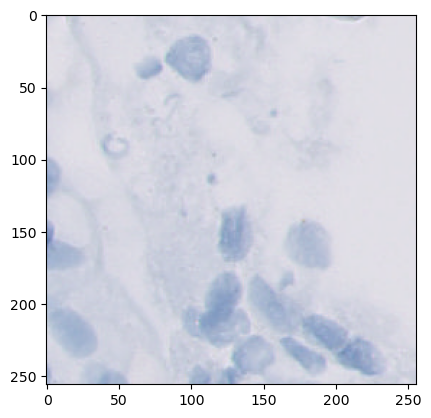

In [7]:
plt.imshow(filtered_data[0][0])

## Autoencoder

In [8]:
"""
Autoencoder has 3 convolutional blocks with one convolutional layer, batch normalization and leakyrelu activation each. 
The size of the convolutional kernel is 3 and the number of neurons and stride of each layer are, respectively, [32,64,64] and [1,2,2].
"""

class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()

        #encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU()
        )

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )

        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )

        #decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )

        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU()
        )

        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.LeakyReLU()
        )

    def forward(self, x):
                            # [batch_size, 3, 256, 256]
        #encoder
        x = self.enc1(x)    #[batch_size, 32, 256, 256]
        x = self.enc2(x)    #[batch_size, 64, 128, 128]
        x = self.enc3(x)    #[batch_size, 64, 64, 64]

        #decoder
        x = self.dec1(x)    #[batch_size, 64, 128, 128]
        x = self.dec2(x)    #[batch_size, 32, 256, 256]
        x = self.dec3(x)    #[batch_size, 3, 256, 256]

        return x
    

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#load save model
model = Autoencoder().to(device)

#load the saved model
model.load_state_dict(torch.load('auto.pth',  map_location=torch.device(device)))

cpu


<All keys matched successfully>

### Red Like Pixels Computation

In [10]:
# Define a function to compute the red like percentage of an image

def red_percentage(img):
    #convert the image to HSV color space
    hsv = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2HSV)

    #compute the number of pixels with hue in [-20, 20]
    
    red_like_pixels = np.sum(np.logical_or((hsv[:, :, 0] < 20) & (hsv[:, :, 0] >= 0), (hsv[:, :, 0] > 160) & (hsv[:, :, 0] <= 180)))

    #compute the percentage of red-like pixels
    red_like_percentage = 100 * (red_like_pixels / (256 * 256))

    return red_like_percentage

In [11]:
def imgback2normal(img):
    img = img.squeeze(0)
    img = img.permute(1, 2, 0)
    img = img.detach().numpy()
    img = img.astype(int)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


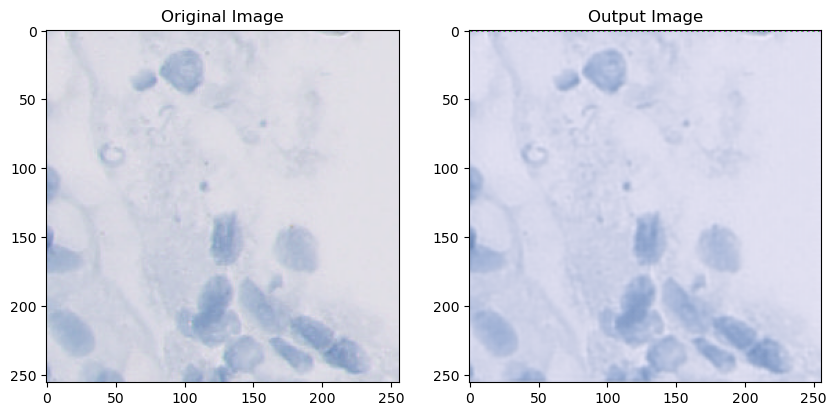

In [12]:
img = filtered_data[0][0]
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)
img = img.permute(0, 3, 1, 2)
img = img.to(device)


#feed the image to the model
output = model(img)

#convert the image to its original shape
img = imgback2normal(img)
output = imgback2normal(output)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(output)
plt.title('Output Image')
plt.show()

In [13]:
#compute red like percentage of the original image
print('Red like percentage of the original image: ' + str(red_percentage(img)) + '%')

#compute red like percentage of the output image
print('Red like percentage of the output image: ' + str(red_percentage(output)) + '%')

#show an example of an infected image and its red like percentage
print('Red like percentage of an infected sample: ' + str(red_percentage(infected_data[0][0])) + '%')

Red like percentage of the original image: 0.00152587890625%
Red like percentage of the output image: 0.0%
Red like percentage of an infected sample: 6.19049072265625%


In [14]:
Fr = red_percentage(img) - red_percentage(output)
print('Fr: ' + str(Fr))

Fr: 0.00152587890625


In [15]:
Fr = (red_percentage(output)+0.01) / (red_percentage(img)+0.01)
print('Fr: ' + str(Fr))

Fr: 0.8676127938995976


#### Example with infected samples

In [16]:
#try the model with an infected image
infected_img = infected_data[0][0]
infected_img = torch.from_numpy(infected_img).float()
infected_img = infected_img.unsqueeze(0)
infected_img = infected_img.permute(0, 3, 1, 2)
infected_img = infected_img.to(device)

#feed the image to the model
infected_output = model(infected_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


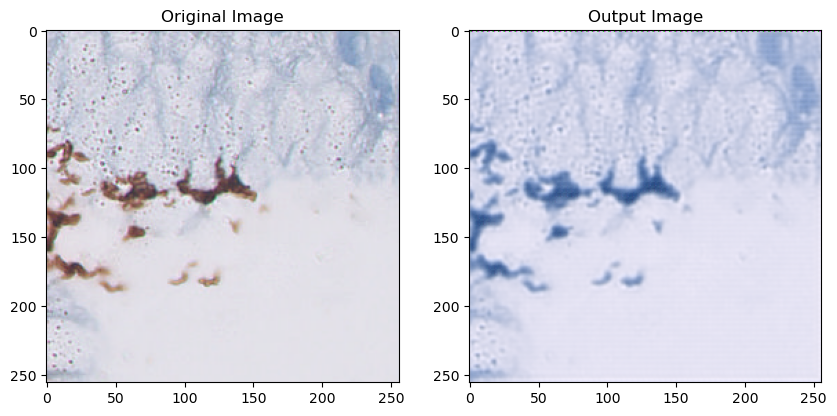

In [17]:
infected_img = imgback2normal(infected_img)
infected_output = imgback2normal(infected_output)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(infected_img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(infected_output)
plt.title('Output Image')
plt.show()

In [18]:
infected_Fr = (red_percentage(infected_output)+0.01) / (red_percentage(infected_img)+0.01)
infected_Fr

0.006534576042014064

In [19]:
infected_Fr = red_percentage(infected_img) - red_percentage(infected_output)
print('Fr: ' + str(infected_Fr))

Fr: 6.15997314453125


### Test on Infected Samples

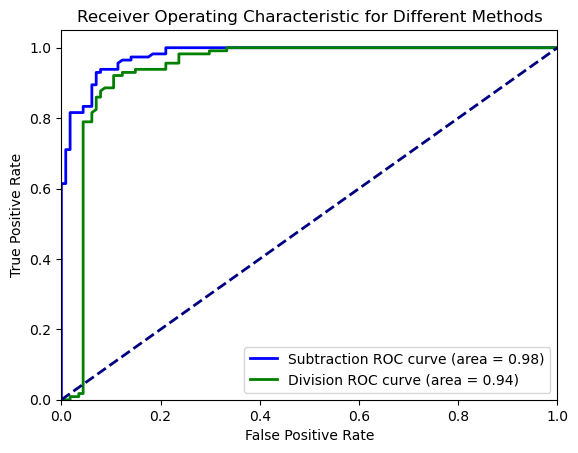

In [187]:
# Assuming 'infected_data' and 'filtered_data' are already defined
train_infected_data = infected_data[:int(len(infected_data)*0.7)]
train_filtered_data = filtered_data[:int(len(filtered_data)*0.7)]
train_data = train_infected_data + train_filtered_data
train_dataset = Dataset(train_data)

test_infected_data = infected_data[int(len(infected_data)*0.7):]
test_filtered_data = filtered_data[int(len(filtered_data)*0.7):]
test_data = test_infected_data + test_filtered_data
test_dataset = Dataset(test_data)

true_labels_subs = [1 if label == 1 else 0 for _, label in train_data]  # Assuming label 1 is for infected
true_labels_div = [1 if label == -1 else 0 for _, label in train_data]  # division classifies inversely
scores_subs = []
scores_div = []

# Predict scores for each method
for img, _ in train_dataset:
    img = img.to(device)
    output = model(img)

    img = imgback2normal(img)
    output = imgback2normal(output)

    Fr_subs = red_percentage(img) - red_percentage(output)
    Fr_div = red_percentage(output) + 0.01 / (red_percentage(img) + 0.01)

    scores_subs.append(Fr_subs)
    scores_div.append(Fr_div)

# Calculate ROC curves and AUC scores
fpr_subs, tpr_subs, thresholds_subs = roc_curve(true_labels_subs, scores_subs)
roc_auc_subs = roc_auc_score(true_labels_subs, scores_subs)

fpr_div, tpr_div, thresholds_div = roc_curve(true_labels_div, scores_div)
roc_auc_div = roc_auc_score(true_labels_div, scores_div)

# Plot ROC curves
plt.figure()

plt.plot(fpr_subs, tpr_subs, color='blue', lw=2, label=f'Subtraction ROC curve (area = {roc_auc_subs:.2f})')
plt.plot(fpr_div, tpr_div, color='green', lw=2, label=f'Division ROC curve (area = {roc_auc_div:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Different Methods')
plt.legend(loc="lower right")
plt.show()

Optimal threshold for subtraction method: 0.1953125
Optimal threshold for division method: 0.057209899994413095


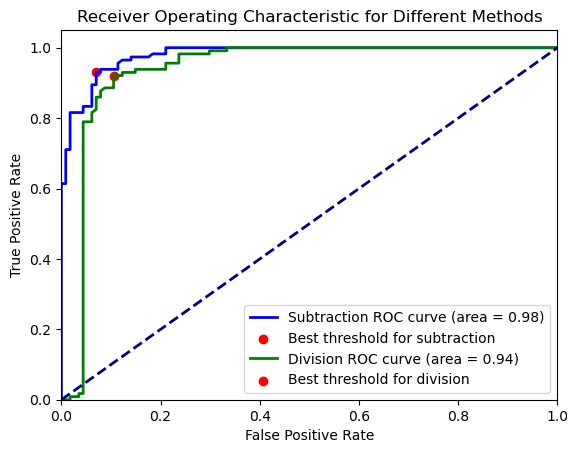

In [188]:
# Calculate the Euclidean distance for each point on the ROC curve from the top-left corner (0,1)
distances_subs = (1-tpr_subs)**2 + fpr_subs**2

min_distance_subs = np.min(distances_subs)  # The minimum distance
optimal_idx_subs = np.argmin(distances_subs)  # The index of the optimal threshold

# Get the optimal threshold value
optimal_threshold_subs = thresholds_subs[optimal_idx_subs]

# Similarly for the 'div' method
distances_div = (1-tpr_div)**2 + fpr_div**2
min_distance_div = np.min(distances_div)
optimal_idx_div = np.argmin(distances_div)

optimal_threshold_div = thresholds_div[optimal_idx_div]

# Now, you have the optimal thresholds for both methods
print(f"Optimal threshold for subtraction method: {optimal_threshold_subs}")
print(f"Optimal threshold for division method: {optimal_threshold_div}")

# And if you want to plot these points on the ROC curve
plt.figure()

plt.plot(fpr_subs, tpr_subs, color='blue', lw=2, label=f'Subtraction ROC curve (area = {roc_auc_subs:.2f})')
plt.scatter(fpr_subs[optimal_idx_subs], tpr_subs[optimal_idx_subs], marker='o', color='red', label='Best threshold for subtraction')

plt.plot(fpr_div, tpr_div, color='green', lw=2, label=f'Division ROC curve (area = {roc_auc_div:.2f})')
plt.scatter(fpr_div[optimal_idx_div], tpr_div[optimal_idx_div], marker='o', color='red', label='Best threshold for division')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Different Methods')
plt.legend(loc="lower right")
plt.show()

division


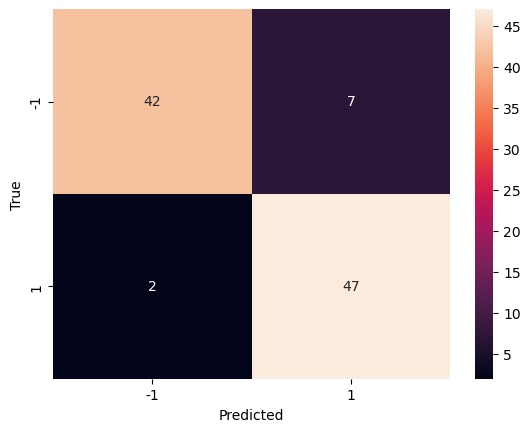



substraction


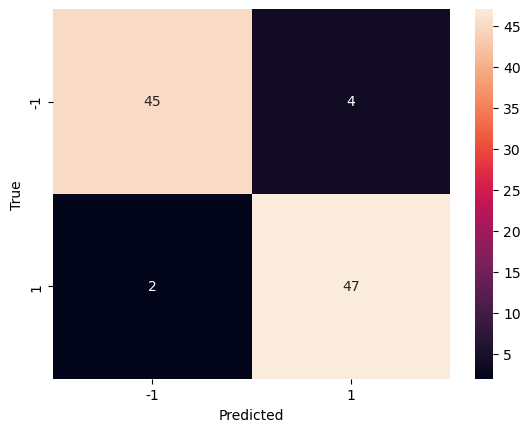

,Precision,Recall,F1,Accuracy
Division,[0.8703703703703703],[0.9591836734693877],[0.912621359223301],[0.9081632653061225]
Substraction,[0.9215686274509803],[0.9591836734693877],[0.9400000000000001],[0.9387755102040817]


In [189]:
predicted_labels_subs = []
predicted_labels_div = []

for window in test_dataset:
    img = window[0]
    img = img.to(device)
    #feed the image to the model
    output = model(img)

    img = imgback2normal(img)
    output = imgback2normal(output)

    Fr_subs = red_percentage(img) - red_percentage(output)
    Fr_div = (red_percentage(output)+0.01) / (red_percentage(img)+0.01)

    # if Fr_subs >= fpr_subs[optimal_idx_subs]:
    if Fr_subs >= optimal_threshold_subs:
        predicted_labels_subs.append(1)
        
    else:
        predicted_labels_subs.append(-1)
    
    #if Fr_div >= fpr_div[optimal_idx_div]:
    if Fr_div >= optimal_threshold_div:
        predicted_labels_div.append(-1)
        
    else:
        predicted_labels_div.append(1)

predicted_labels = {'division': predicted_labels_div, 'substraction': predicted_labels_subs}

y_true = [d[1] for d in test_data]
all_metrics = []
for key, value in predicted_labels.items():
    print(key)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, value, average='binary')
    accuracy = accuracy_score(y_true, value)
    metrics = {'Precision': [precision], 'Recall': [recall], 'F1': [f1], 'Accuracy': [accuracy]}
    all_metrics.append(metrics)

    #compute confusion matrix
    cm = confusion_matrix(y_true, value)

    #plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=['-1', '1'], yticklabels=['-1', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print('\n')

#show precision, recall, f1 and accuracy in a table
metrics_table = pd.DataFrame(data=all_metrics, index=['Division', 'Substraction'])

metrics_table.head()